In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Loading of data

## `stocks` dataset

Load `stocks` dataset, parse corresponding dates, and set index by `firm`.

In [2]:
stocks = pd.read_csv(
    "stocks.csv",
    parse_dates=["q"],
    index_col=["firm"]
)

Convert timestamps to periods.

In [3]:
stocks["q"] = stocks["q"].dt.to_period("Q")

Add `q` to create a multi-index.

In [4]:
stocks = stocks.set_index(["q"], append=True)

Then sort by `firm` for convenience.

In [5]:
stocks = stocks.sort_values(by=["firm", "q"])

Check if there are `nan` values on the `firm` column.

In [6]:
stocks.head()

revenue       cogs       sgae  otheropexp  extraincome  finexp  \
firm q                                                                          
A    2000Q1        NaN        NaN        NaN         NaN          NaN     NaN   
     2000Q2  2485000.0  1261000.0  1010000.0         0.0      42000.0     0.0   
     2000Q3  2670000.0  1369000.0  1091000.0         0.0      28000.0     0.0   
     2000Q4  3372000.0  1732000.0  1182000.0         0.0      10000.0     0.0   
     2001Q1  2841000.0  1449000.0  1113000.0         0.0      -6000.0     0.0   

             incometax  totalassets  totalliabilities  shortdebt  longdebt  \
firm q                                                                       
A    2000Q1        NaN          NaN               NaN        NaN       NaN   
     2000Q2    90000.0    7321000.0         2679000.0   512000.0       0.0   
     2000Q3    83000.0    7827000.0         2925000.0   528000.0       0.0   
     2000Q4   163000.0    8425000.0         3160000.0   830000.0       0.0   
     2001Q1   119000.0    9208000.0         3667000.0   556000.0       0.0   

             stockholderequity   adjprice  originalprice  sharesoutstanding  \
firm q                                                                        
A    2000Q1                NaN  63.761670       104.0000         452000.000   
     2000Q2          4642000.0  45.215607        73.7500         452271.967   
     2000Q3          4902000.0  30.003238        48.9375         453014.579   
     2000Q4          5265000.0  33.566841        54.7500         456366.381   
     2001Q1          5541000.0  18.840347        30.7300         456769.737   

             fiscalmonth    year  cto  
firm q                                 
A    2000Q1          NaN  2000.0  1.0  
     2000Q2          6.0  2000.0  2.0  
     2000Q3          9.0  2000.0  3.0  
     2000Q4         12.0  2000.0  4.0  
     2001Q1          3.0  2001.0  1.0

Check if there are `nan` values in the `DataFrame`'s multi-index.

In [7]:
stocks.index.get_level_values("firm").isna().sum()

1

In [8]:
stocks.index.get_level_values("q").isna().sum()

1

Drop `nan` values in multi-index since there is only one `nan` value for every multi-index.

In [9]:
stocks = stocks.loc[stocks.index.dropna()]

In [10]:
stocks.index.get_level_values("firm").isna().sum()

0

In [11]:
stocks.index.get_level_values("q").isna().sum()

0

# `us_firms` dataset

In [12]:
us_firms = pd.read_csv("usfirms2022.csv")  # Load US firms dataset

In [13]:
us_firms.head()

,Ticker,Name,N,Class,Country\nof Origin,Type of Asset,Sector NAICS\nlevel 1,Exchange / Src,Sector\nEconomatica,Sector NAICS\nlast available,partind
0,FLWS,1 800 Flowers Com Inc,1,Com A,US,Stock,Retail Trade,NASDAQ,Trade,Retail Trade,-
1,TXG,"10x Genomics, Inc",2,Com A,US,Stock,Manufacturing,NASDAQ,Electric Electron,"Navigational, Measuring, Electromedical, and C...",-
2,GOED,1847 Goedeker Inc,3,Com,US,Stock,Retail Trade,AMEX,Trade,Furniture and Home Furnishings Stores,-
3,ONEM,"1life Healthcare, Inc",4,Com,US,Stock,Health Care and Social Assistance,NASDAQ,Other,Offices of Physicians,-
4,SRCE,1st Source Corp,5,Com,US,Stock,Finance and Insurance,NASDAQ,Finance and Insurance,Depository Credit Intermediation,-


Rename some of the columns so that they are easier to read.

In [14]:
us_firms = us_firms.rename(
    columns = {
        "Ticker": "firm",
        "Sector NAICS\nlevel 1": "industry",
        "Country\nof Origin": "country",
        "Exchange / Src": "exchange"
    }
)

Drop other industry-related columns since only NAICS level 1 will be used for this business case.

In [15]:
us_firms.drop(["Sector NAICS\nlast available", "Sector\nEconomatica"], axis=1, inplace=True)

Set `firm` as index for `us_firms`.

In [16]:
us_firms = us_firms.set_index("firm")

In [17]:
us_firms.head()

,Name,N,Class,country,Type of Asset,industry,exchange,partind
firm,,,,,,,,
FLWS,1 800 Flowers Com Inc,1,Com A,US,Stock,Retail Trade,NASDAQ,-
TXG,"10x Genomics, Inc",2,Com A,US,Stock,Manufacturing,NASDAQ,-
GOED,1847 Goedeker Inc,3,Com,US,Stock,Retail Trade,AMEX,-
ONEM,"1life Healthcare, Inc",4,Com,US,Stock,Health Care and Social Assistance,NASDAQ,-
SRCE,1st Source Corp,5,Com,US,Stock,Finance and Insurance,NASDAQ,-


# Prepare dataframe for business case

In [18]:
firms = stocks.copy()

Peform join on `us_firms` to get industry of each firm.

In [19]:
firms = firms.join(
    us_firms["industry"],
    lsuffix="_caller",
    rsuffix="_other",
    on="firm"
)

In [20]:
firms.head()

revenue       cogs       sgae  otheropexp  extraincome  finexp  \
firm q                                                                          
A    2000Q1        NaN        NaN        NaN         NaN          NaN     NaN   
     2000Q2  2485000.0  1261000.0  1010000.0         0.0      42000.0     0.0   
     2000Q3  2670000.0  1369000.0  1091000.0         0.0      28000.0     0.0   
     2000Q4  3372000.0  1732000.0  1182000.0         0.0      10000.0     0.0   
     2001Q1  2841000.0  1449000.0  1113000.0         0.0      -6000.0     0.0   

             incometax  totalassets  totalliabilities  shortdebt  longdebt  \
firm q                                                                       
A    2000Q1        NaN          NaN               NaN        NaN       NaN   
     2000Q2    90000.0    7321000.0         2679000.0   512000.0       0.0   
     2000Q3    83000.0    7827000.0         2925000.0   528000.0       0.0   
     2000Q4   163000.0    8425000.0         3160000.0   830000.0       0.0   
     2001Q1   119000.0    9208000.0         3667000.0   556000.0       0.0   

             stockholderequity   adjprice  originalprice  sharesoutstanding  \
firm q                                                                        
A    2000Q1                NaN  63.761670       104.0000         452000.000   
     2000Q2          4642000.0  45.215607        73.7500         452271.967   
     2000Q3          4902000.0  30.003238        48.9375         453014.579   
     2000Q4          5265000.0  33.566841        54.7500         456366.381   
     2001Q1          5541000.0  18.840347        30.7300         456769.737   

             fiscalmonth    year  cto       industry  
firm q                                                
A    2000Q1          NaN  2000.0  1.0  Manufacturing  
     2000Q2          6.0  2000.0  2.0  Manufacturing  
     2000Q3          9.0  2000.0  3.0  Manufacturing  
     2000Q4         12.0  2000.0  4.0  Manufacturing  
     2001Q1          3.0  2001.0  1.0  Manufacturing

Remove `-` industry from `firms`.

In [21]:
firms = firms[firms["industry"] != "-"]

In [22]:
firms["industry"].isin(["-"]).sum()

0

# Get financial metrics

The following financial metrics will be computed. It must be noted that the shifting is done by grouping with `groupby` by level 0, that is, by `firm` so that each column is correctly shifted by firm.

In [23]:
firms["cc returns"] = np.log(firms["adjprice"]) - np.log(firms.groupby(level=0)["adjprice"].shift(1))

In [24]:
firms["market value"] = firms["originalprice"] * firms["sharesoutstanding"]

In [25]:
firms["book value"] = firms["totalassets"] - firms["totalliabilities"]

In [26]:
firms["ebit"] = firms["revenue"] - firms["cogs"] - firms["sgae"] - firms["otheropexp"]

In [27]:
firms["net income"] = firms["ebit"] - firms["finexp"] - firms["incometax"] + firms["extraincome"]

In [28]:
firms["book-to-market ratio"] = firms["book value"] / firms["market value"]

The below operations involve the division by zero in some instances, so every zero value in the denominator will be replaced with a `nan` value.

In [29]:
firms["sales annual growth"] = firms["revenue"] \
    / firms.groupby(level=0)["revenue"].shift(4).replace(0, np.nan) - 1

In [30]:
firms["operating profit growth"] = firms["ebit"] \
    / firms.groupby(level=0)["ebit"].shift(4).replace(0, np.nan) - 1

In [31]:
firms["operating profit margin"] = firms["ebit"] / firms["revenue"].replace(0, np.nan)  # Avoid division by 0

In [32]:
firms["short financial leverage"] = firms["shortdebt"] / firms["totalassets"].replace(0, np.nan)

In [33]:
firms["long financial leverage"] = firms["longdebt"] / firms["totalassets"].replace(0, np.nan)

In [34]:
firms["eps"] = firms["net income"] / firms["sharesoutstanding"].replace(0, np.nan)

In [35]:
firms["epsp"] = firms["eps"] / firms["originalprice"].replace(0, np.nan)

# Firm size by industry

## Market value

To get a sense of the market value by firm, a histogram is plotted.

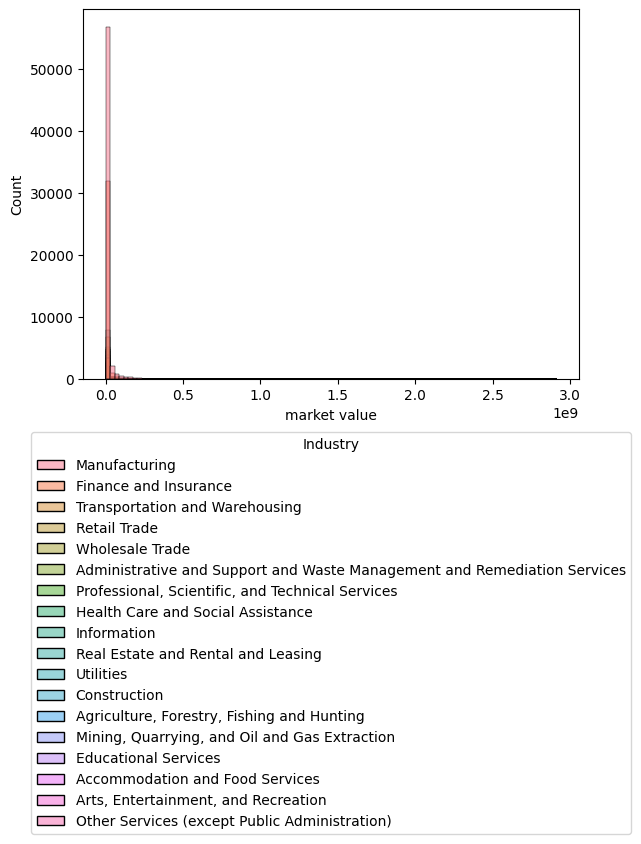

In [36]:
hist = sns.histplot(
    firms, x="market value", bins=100,
    hue="industry", common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, -1.25), title="Industry")

plt.show()

The above histogram denotes that regardless of industry the market value of firms, once plotted in a histogram, is skewed to the left. This is due to the few companies that achieve to become very valuable (Apple, Walmart, Amazon, etc.).

## Book value 

Applying the same logic as before, a histogram for book values is plotted.

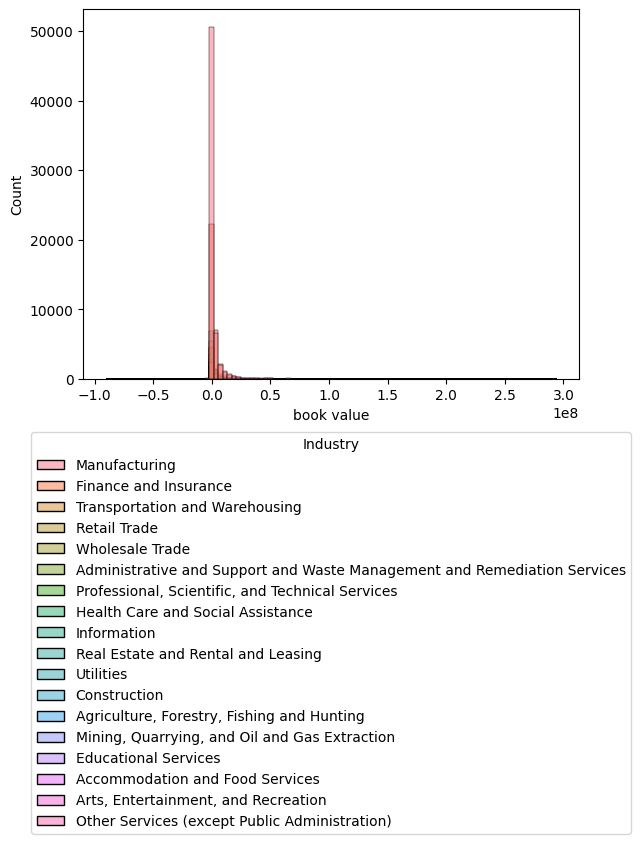

In [37]:
hist = sns.histplot(
    firms, x="book value", bins=100,
    hue="industry", common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, -1.25), title="Industry")

plt.show()

Contrary to the market value, book value is not as skewed to the left as market value is. However, this trend is also independent of industry.

# Firms sales performance and profitability

## Net income

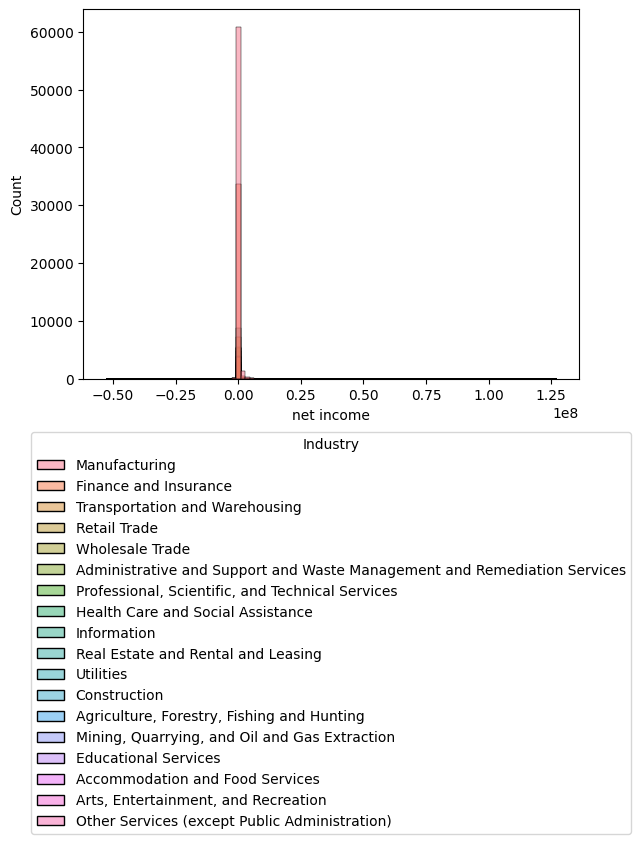

In [38]:
hist = sns.histplot(
    firms, x="net income", bins=100,
    hue="industry", common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, -1.25), title="Industry")

plt.show()

The above histogram shows that the vast majority of firms have net incomes that hardly exceed 2.5 billion dollars.

## EPSP

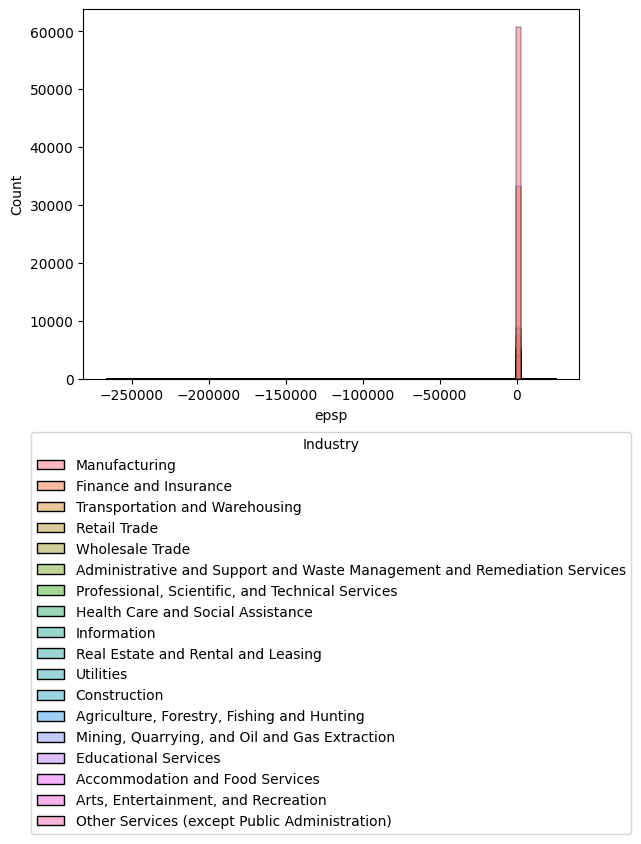

In [39]:
hist = sns.histplot(
    firms, x="epsp", bins=100,
    hue="industry", common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, -1.25), title="Industry")

plt.show()

However, when the histogram is plotted for `epsp`, then it becomes skewed to the right.

# Firms by industry (descriptive statistics)

For the business case only descriptive statistics for the last quarter will be calculated.

In [41]:
last_quarter = firms.index.levels[1][-1]

In [44]:
firms_last_quarter = firms.loc[:, last_quarter, :]

In [53]:
firms_last_quarter.head()

,revenue,cogs,sgae,otheropexp,extraincome,finexp,incometax,totalassets,totalliabilities,shortdebt,...,ebit,net income,book-to-market ratio,sales annual growth,operating profit growth,operating profit margin,short financial leverage,long financial leverage,eps,epsp
firm,,,,,,,,,,,,,,,,,,,,,
A,1607000.0,746000.0,501000.0,0.0,-7000.0,20000.0,59000.0,10455000.0,5333000.0,175000.0,...,360000.0,274000.0,0.144373,0.053770,0.250000,0.224020,0.016738,0.261119,0.917284,0.007723
AA,3644000.0,2767000.0,220000.0,-75000.0,81000.0,30000.0,234000.0,15709000.0,8417000.0,1000.0,...,732000.0,549000.0,0.867355,0.286269,0.730496,0.200878,0.000064,0.109810,2.976438,0.065301
AAIC,10900.0,6374.0,0.0,0.0,-3417.0,0.0,802.0,1084755.0,871057.0,NaN,...,4526.0,307.0,1.877784,0.547197,-0.110281,0.415229,NaN,0.192642,0.008767,0.002698
AAL,13422000.0,0.0,12405000.0,0.0,25000.0,439000.0,127000.0,67963000.0,76385000.0,2106000.0,...,1017000.0,476000.0,-1.022603,0.794865,1.306122,0.075771,0.030987,0.514442,0.732855,0.057796
AAME,44669.0,0.0,46784.0,0.0,0.0,0.0,-436.0,379274.0,270173.0,NaN,...,-2115.0,-1679.0,2.003177,-0.131916,-1.563399,-0.047348,NaN,0.088954,-0.082310,-0.030828


A histogram is plotted to get the most predominant industry by number of firms.

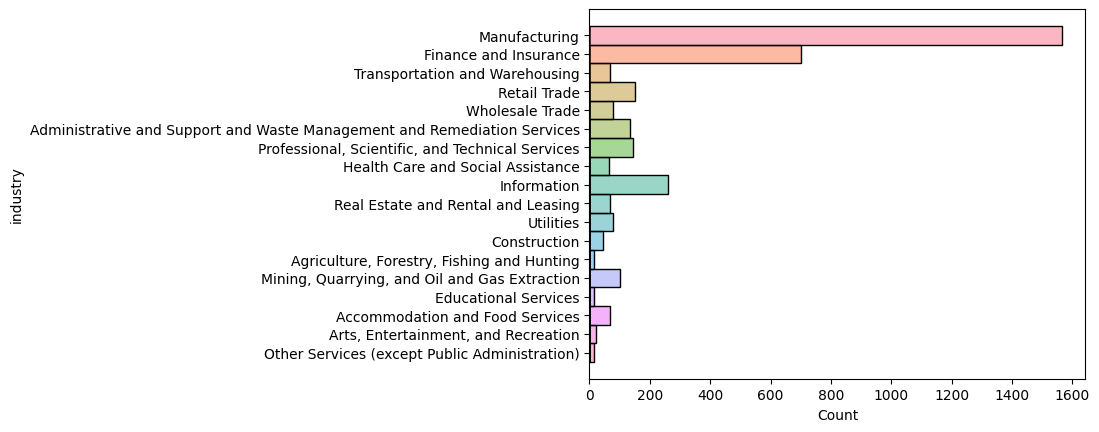

In [54]:
sns.histplot(
    data=firms_last_quarter,
    y="industry",
    hue="industry",
    common_norm=False,
    legend=False
);

From the above histogram it can be concluded that the most predominant industry is manufacturing while the less predominant is educational services. The former can also be seen numerically:

In [62]:
firms_last_quarter["industry"].value_counts()

Manufacturing                                                               1565
Finance and Insurance                                                        701
Information                                                                  261
Retail Trade                                                                 152
Professional, Scientific, and Technical Services                             145
Administrative and Support and Waste Management and Remediation Services     133
Mining, Quarrying, and Oil and Gas Extraction                                103
Wholesale Trade                                                               79
Utilities                                                                     77
Transportation and Warehousing                                                69
Accommodation and Food Services                                               69
Real Estate and Rental and Leasing                                            68
Health Care and Social Assis

### Book value by industry

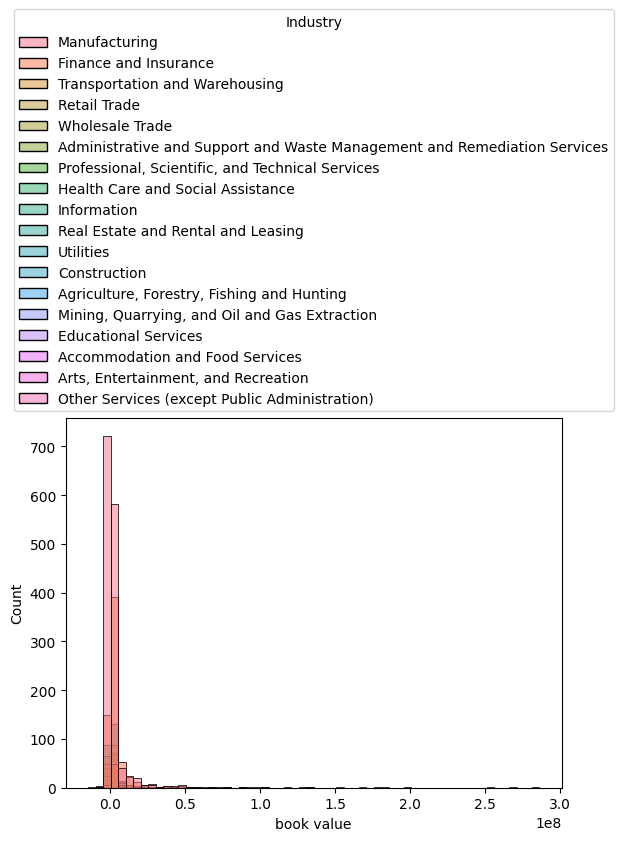

In [64]:
hist = sns.histplot(
    firms_last_quarter, x="book value", bins=60,
    hue="industry", common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.0), title="Industry")

plt.show()

### Market value by industry

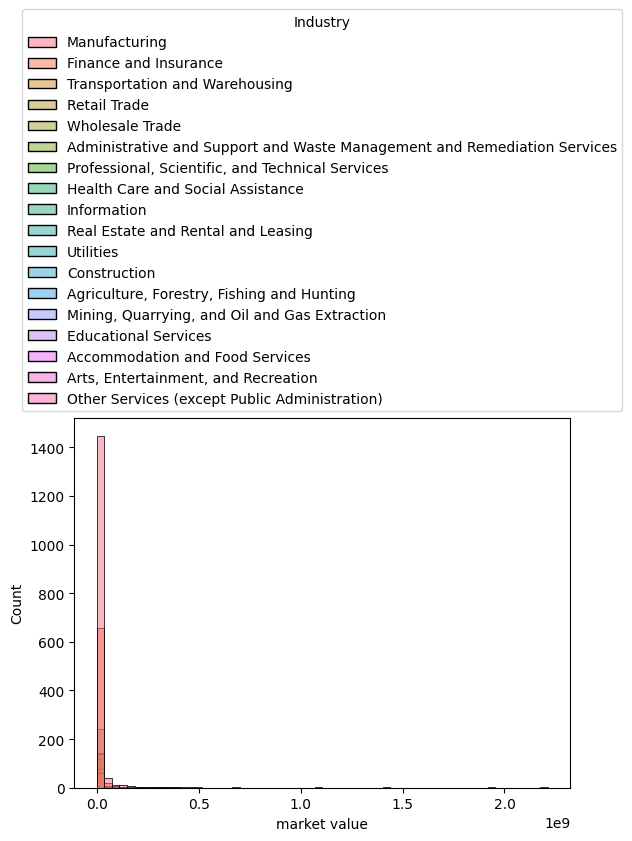

In [65]:
hist = sns.histplot(
    firms_last_quarter, x="market value", bins=60,
    hue="industry", common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.0), title="Industry")

plt.show()

By examining the above histograms, it can be seen that both the market value and book value of the firms across different industries are skewed to the left. Because of this, to get a sense of the typical of these metrics, the median of both metrics is measured.

In [69]:
firms_last_quarter.index.values

array(['A', 'AA', 'AAIC', ..., 'ZWS', 'ZY', 'ZYNE'], dtype=object)

In [71]:
typical_market_value = {
    industry: firms_last_quarter.loc[industry, "market value"].median()
    for industry in firms_last_quarter.index.values
}

AttributeError: 'numpy.float64' object has no attribute 'median'

In [ ]:
typical_market_value = pd.DataFrame(
    data={
        "industry": typical_market_value.keys(),
        "median market value": typical_market_value.values()
    }
)

In [ ]:
typical_book_value = {
    industry: stocks_last_quarter.loc[industry, "book value"].median()
    for industry in stocks_last_quarter.index.levels[0].values
}

In [ ]:
typical_book_value = pd.DataFrame(
    data={
        "industry": typical_book_value.keys(),
        "median book value": typical_book_value.values()
    }
)

In [ ]:
typical_book_value.head()

In [ ]:
bar = sns.barplot(data=typical_market_value, x="median market value", y="industry", hue="industry", dodge=False)

sns.move_legend(bar, "lower center", bbox_to_anchor=(0.5, 1.0), title="Industry")

plt.show()

In [ ]:
bar = sns.barplot(data=typical_book_value, x="median book value", y="industry", hue="industry", dodge=False)

sns.move_legend(bar, "lower center", bbox_to_anchor=(0.5, 1.0), title="Industry")

plt.show()

In [ ]:
typical_firm_size = typical_market_value.merge(typical_book_value, on="industry")

In [ ]:
typical_firm_size.head()

## Statistical modeling

### Winsorization

In [ ]:
stocks_manufacturing = stocks.loc["Manufacturing"]

In [ ]:
stocks_manufacturing.info()

In [ ]:
stocks_manufacturing = stocks_manufacturing.clip(  # Winsorize dataset to remove most outliers
    lower=stocks_manufacturing.quantile(0.02),
    upper=stocks_manufacturing.quantile(0.98),
    axis=1
)

In [ ]:
stocks_manufacturing["firm size"] = np.where(
    stocks_manufacturing["market value"] < stocks_manufacturing["market value"].quantile(1/3),
    "small",
    "medium"
)

In [ ]:
stocks_manufacturing["firm size"] = np.where(
    stocks_manufacturing["market value"] >= stocks_manufacturing["market value"].quantile(2/3),
    "big",
    stocks_manufacturing["firm size"]
)

In [ ]:
stocks_manufacturing["firm size"].value_counts()

In [ ]:
dummy_columns = pd.get_dummies(stocks_manufacturing["firm size"])

In [ ]:
stocks_manufacturing = stocks_manufacturing.merge(dummy_columns, on=["firm", "q"])

In [ ]:
dependent_variable = "cc returns"

In [ ]:
independent_variables = [
    "eps",
    "net income",
    "operating profit margin",
    "operating profit growth",
    "sales annual growth", 
    "ebit",
    "short financial leverage",
    "long financial leverage",
    "book-to-market ratio"
]

In [ ]:
dummies = [
    "small",
    "medium",
    "big"
]

In [ ]:
columns = [dependent_variable] + independent_variables + dummies

In [ ]:
stats_model = stocks_manufacturing[columns]

Apply min-max normalization to values.

In [ ]:
stats_model = pd.DataFrame(
    MinMaxScaler().fit_transform(stats_model),
    columns=columns
)

In [ ]:
stats_model.describe()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,12))

n_fig = 0

for ivar in independent_variables:
    splot = sns.scatterplot(
        data=stats_model,
        x=ivar,
        y=dependent_variable,
        ax=axes[n_fig // 3, n_fig % 3]
    )
    
    n_fig += 1
    
fig.tight_layout()

As it can be seen from the above histogram, there is no linear regression in any of the considered parameters. However, to train the linear regression for this deliverable, `net income`, `short financial leverage`, `sales annual growth`, and `eps` will be used for the model as they appear to have at least some degree of linear behaviour compared to the rest of variables that do not seem to be lineary related.

In [ ]:
independent_variables_model = ["eps", "net income", "short financial leverage", "sales annual growth"]

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))

n_fig = 0

for ivar in independent_variables_model:
    hist = sns.histplot(stats_model, x=ivar, ax=axes[n_fig])
    n_fig += 1
    
plt.tight_layout()

From the above histograms, it is possible to get a sense of the typical values for each of the factors. Because three of the histograms are skewed to the left, the typical value of these factor will correspond to the median. For the `eps` factor the mean is more appropiate sinde the distribution appears to have a normal behaviour.

Another remarkable insight is that histogram still present some outliers at their tails even after applying winsorization of 1% to the data.

In [ ]:
typical_eps = stats_model["eps"].mean()

In [ ]:
typical_net_income = stats_model["net income"].median()

In [ ]:
typical_short_financial_leverage = stats_model["short financial leverage"].median()

In [ ]:
typical_sales_annual_growth = stats_model["sales annual growth"].median()

In [ ]:
print("Typical eps:", typical_eps)

In [ ]:
print("Typical net income:", typical_net_income)

In [ ]:
print("Typical short financial leverage:", typical_short_financial_leverage)

In [ ]:
print("Typical sales annual growth:", typical_sales_annual_growth)

Additionally, to get a sense of the dispersion of the chosen factor, the standard deviation can be calculated for each factor.

In [ ]:
eps_std = stats_model["eps"].std()

In [ ]:
net_income_std = stats_model["net income"].std()

In [ ]:
short_financial_leverage_std = stats_model["short financial leverage"].std()

In [ ]:
sales_annual_growth_std = stats_model["sales annual growth"].std()

In [ ]:
print("eps standard deviation:", eps_std)

In [ ]:
print("Net income standard deviation:", net_income_std)

In [ ]:
print("Short financial leverage standard deviation:", short_financial_leverage_std)

In [ ]:
print("Sales annual growth standard deviation:", sales_annual_growth_std)

# Multiple regression

In [ ]:
stats_model

In [ ]:
X = stats_model[independent_variables_model+dummies]

In [ ]:
y = stats_model[[dependent_variable]]

In [ ]:
X.isna().sum()

In [ ]:
X.notna().sum()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
X_vif = X.dropna()

In [ ]:
vif_df = pd.DataFrame()

In [ ]:
vif_df["feature"] = X_vif.columns

In [ ]:
vif_df["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(len(X_vif.columns))
]

In [ ]:
vif_df

From the above VIF values it can be said that the dummy values may present multicollinearity due to their high VIF values. Multicollinearity is a measure of how correlated some features are and it may hinder the model from distinguishing between their individual effects on the dependent variable.